# ロジスティック回帰を利用したクラス分類
氏名:鴛尾 直樹  
学籍番号:20N2100010D

## 概要


機械学習と分類問題の理解を目的として、「身長と体重から男性か女性かを予測して見分ける分類器」の作成を試みる。
モデルはロジスティック回帰モデル、学習方法はニュートン法を採用する。

### 問題設定とアプローチ


タスク：身長と体重から性別を分類する(2クラス分類)  
モデリング：ロジスティック回帰  
学習方法：ニュートン法  

【データについて】   
特徴量：身長、体重  
クラス：男、女  
今回使用するデータ（訓練データ・テストデータ）は、冒頭で人工的に生成することにする。

## 準備

### 人工データの生成
特徴量$(体重,身長)$、ラベル:$(男,女)$を持ったデータセットを人工的に生成する。

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

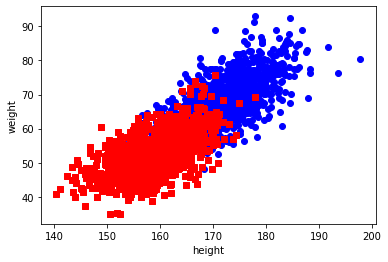

In [ ]:
#人工の訓練データセットを生成(特徴量:身長、体重/クラス:性別)
#訓練データ生成時の乱数の種は1とする。
np.random.seed(1)

#訓練データの個数（各性別の個数。実際にはこれの2倍）
num_train = 1000

#データ生成
male = pd.DataFrame()
female = pd.DataFrame()

m_height = np.random.normal(171.7,6.6,num_train)
f_height = np.random.normal(158.3,5.7,num_train)

m_bmi = np.random.normal(23.12,2,num_train)
f_bmi = np.random.normal(20.82,2,num_train)

male["height"] =np.sort(m_height)
male["weight"] = (male["height"] * 0.01) ** 2 * m_bmi
male["sex"] = 1 #男：1,女:0とする

female["height"] = np.sort(f_height)
female["weight"] = (female["height"] * 0.01) ** 2 * f_bmi
female["sex"] = 0 #男：1,女:0とする

#データ連結
df = pd.concat([male,female]) # 2*num_train個の全てのデータセット 
#インデックスの付けなおし(仕様上必要なおまじない)
df.index = range(0,len(df))
#print(df.index.duplicated())

#可視化
fig, ax = plt.subplots()
ax.set_xlabel("height")
ax.set_ylabel("weight")
ax.scatter(male["height"],male["weight"] , marker='o', c='b') # 男
ax.scatter(female["height"],female["weight"] , marker='s',  c='r') #女

# このままで線形分離可能なので、この特徴量をそのまま使う。

### 特徴量の基底の選択
線形分離可能な形のデータなので、非線形な基底は特に加えず、生のデータの特徴量をそのまま基底に採用する。

In [ ]:
#特徴量の基底を決める
def feature(x1,x2):
    phi = np.row_stack((np.ones(len(x1)),x1))
    phi = np.row_stack((phi,x2))
#    phi = np.row_stack((phi,x1*x2))
#    phi = np.row_stack((phi,x1**2))
#    phi = np.row_stack((phi,x2**2))
#    phi = np.row_stack((phi,x1**3))
#    phi = np.row_stack((phi,x2**3))
#    phi = np.row_stack((phi,x1*x1*x2))
#    phi = np.row_stack((phi,x1*x2*x2))
#    phi = np.row_stack((phi,x1**4))
#    phi = np.row_stack((phi,x2**4))
#    phi = np.row_stack((phi,x1*x1*x1*x2))
#    phi = np.row_stack((phi,x1*x1*x2*x2))
#    phi = np.row_stack((phi,x1*x2*x2*x2))
    return(phi.T)  # 見やすさのため、縦に並べた形にする

# phi:全訓練データの特徴ベクトルを縦に並べたもの(サイズ＝データ数×基底数 の行列)
phi = feature(df["height"],df["weight"]) 
d = len(phi[0]) #特徴量の個数 
# y:全訓練データのラベル(クラス)を並べたもの
y = df["sex"]
print("y:",y)

print("phi:",phi)
print("phiは各φ(x_i)を並べたもの。")


y: 0       1
1       1
2       1
3       1
4       1
       ..
1995    0
1996    0
1997    0
1998    0
1999    0
Name: sex, Length: 2000, dtype: int64
phi: [[  1.         151.54515509  55.34568075]
 [  1.         153.265639    55.43158324]
 [  1.         153.27942372  52.21383308]
 ...
 [  1.         174.41560883  58.20161107]
 [  1.         174.92865995  67.55473093]
 [  1.         177.86618156  69.26604431]]
phiは各φ(x_i)を並べたもの。


## モデルの学習(ロジスティック回帰×ニュートン法)

ニュートン法を使ってロジスティック回帰モデルの学習を行う。

wの初期値: [0 0 0]
sの初期値の中身: [0.5 0.5 0.5 ... 0.5 0.5 0.5]
重み付き行列Sの初期値の中身: [[0.25 0.   0.   ... 0.   0.   0.  ]
 [0.   0.25 0.   ... 0.   0.   0.  ]
 [0.   0.   0.25 ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 0.25 0.   0.  ]
 [0.   0.   0.   ... 0.   0.25 0.  ]
 [0.   0.   0.   ... 0.   0.   0.25]]
ヘッセ行列 H の初期値の中身: [[5.00000000e+02 8.26029793e+04 3.01680636e+04]
 [8.26029793e+04 1.36883850e+07 5.02448077e+06]
 [3.01680636e+04 5.02448077e+06 1.87663196e+06]]
Hの厳密な逆行列： [[ 1.23103935e+00 -9.55715416e-03  5.79850724e-03]
 [-9.55715416e-03  7.84363152e-05 -5.63674311e-05]
 [ 5.79850724e-03 -5.63674311e-05  5.82358930e-05]]
Hの擬逆行列(一般化逆行列): [[ 1.23103935e+00 -9.55715416e-03  5.79850724e-03]
 [-9.55715416e-03  7.84363152e-05 -5.63674311e-05]
 [ 5.79850724e-03 -5.63674311e-05  5.82358930e-05]]
w0: [  0.         -18.18797486 -29.85479281 -38.72342733 -42.78991637
 -43.41827936 -43.43087338 -43.43087833 -43.43087833 -43.43087833
 -43.43087833 -43.43087833 -43.43087833 -43.43087833 -43.43087833
 -4

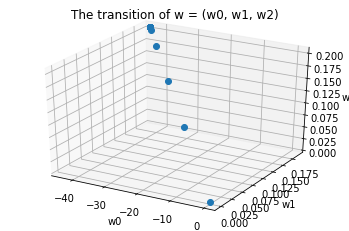

wの推移: [[  0.           0.           0.        ]
 [-18.18797486   0.07913695   0.08475981]
 [-29.85479281   0.12995929   0.14003663]
 [-38.72342733   0.16813738   0.18349232]
 [-42.78991637   0.18542489   0.20402174]
 [-43.41827936   0.18806947   0.20726448]
 [-43.43087338   0.18812208   0.20733049]
 [-43.43087833   0.1881221    0.20733051]
 [-43.43087833   0.1881221    0.20733051]
 [-43.43087833   0.1881221    0.20733051]
 [-43.43087833   0.1881221    0.20733051]
 [-43.43087833   0.1881221    0.20733051]
 [-43.43087833   0.1881221    0.20733051]
 [-43.43087833   0.1881221    0.20733051]
 [-43.43087833   0.1881221    0.20733051]
 [-43.43087833   0.1881221    0.20733051]
 [-43.43087833   0.1881221    0.20733051]
 [-43.43087833   0.1881221    0.20733051]
 [-43.43087833   0.1881221    0.20733051]
 [-43.43087833   0.1881221    0.20733051]]
Ewの推移: [1386.29436112  688.07639598  560.26962897  529.29362404  525.94755493
  525.88885595  525.88883328  525.88883328  525.88883328  525.88883328
  52

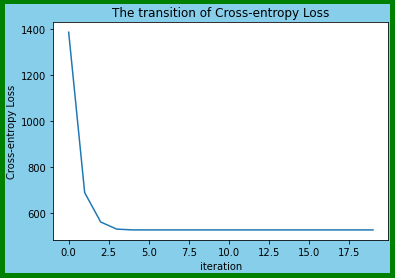

In [ ]:
#シグモイド関数
def sigmoid(a):
  return 1.0/(1 + np.exp(-a))

#損失関数 (交差エントロピー誤差関数)
def en_error(s,y):
  atai = 0
  for i in range(len(df)): #和の実行
      atai -= np.log(y[i]*s[i] + (1-y[i])*(1-s[i]))  #エラー発生:ValueError: cannot reindex from a duplicate axis
  return atai

#パラメーターwの初期化
#wの初期パラメーターを任意に設定
w = np.array([0,0,0])
w_ini = w
print("wの初期値:",w_ini)


wDotPhiZero = np.dot(w.T,phi[0].T)

# s: φ(x_i)をシグモイド関数に入れて出力したものをs_iとして、各s_iを縦に並べたもの。sは1×2000行列
s = np.vectorize(sigmoid)(np.dot(w.T,phi.T)) # 1×d行列とd×1行列の計算を、データ数個まとめて行う  
print("sの初期値の中身:",s) #エラーチェック用

#重み付き行列を計算
def S_(s): #引数sは以下
  S_ij = np.empty(len(s)) #重み付き行列の訓練データの数だけの対角成分だけをかき集めて並べたもの
  for i in range(len(s)):
    S_ij[i] = s[i] * (1-s[i]) 
  return np.diag(S_ij) # s[i] * (1-s[i]) を対角成分に持つ対角行列を返す

#重み付き行列S
S = S_(s)
print("重み付き行列Sの初期値の中身:",S) #エラーチェック用
    #wの初期値の値によっては、Sの初期値の中身が全部ゼロになってしまう場合がある（エラー？）

#ヘッセ行列
H = np.dot(np.dot(phi.T,S),phi)

#H = np.array([[1,0,0],[0,1,0],[0,0,1]]) #エラーチェック用
print("ヘッセ行列 H の初期値の中身:",H) #エラーチェック用
invH = np.linalg.inv(H)
pinvH = np.linalg.pinv(H)
print("Hの厳密な逆行列：",invH)
print("Hの擬逆行列(一般化逆行列):",pinvH)
 #wの初期値の値によっては、Hの初期値の中身が全部ゼロになってしまう場合がある（エラー？）

#ニュートン法
#wと交差エントロピー誤差の推移の履歴を保存する変数
w_list = np.empty((0,3))
Ew_list = np.empty(0)

for i in range(20):
  #wと交差エントロピー誤差の推移の履歴を保存
  w_list = np.append(w_list,np.array([w]), axis=0)
  Ew_list = np.append(Ew_list,en_error(s,y))

  #更新式
  w = w - np.dot(np.dot(np.linalg.pinv(H), phi.T), (s - y)) 

  # sを再計算
  s = np.vectorize(sigmoid)(np.dot(w.T,phi.T)).T
  # S,Hを再計算
  S = S_(s)
  H = np.dot(np.dot(phi.T, S),phi)
 # print("i:",i,"w:",w,"s:",s,"S:",S,"H:",H,"y:",y,"en_error:",en_error(s,y))

#wと交差エントロピー誤差の最適解を格納
w_termi = w
Ew_termi = en_error(s,y)

# w0,w1,w2 の推移の履歴
w0_list = w_list.T[0]
w1_list = w_list.T[1]
w2_list = w_list.T[2] 
print("w0:",w0_list)


#ニュートン法の結果
print("[ニュートン法の結果]")

#wの推移
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax0 = fig.add_subplot(111, projection='3d',title="The transition of w = (w0, w1, w2)")
ax0.set_xlabel("w0")
ax0.set_ylabel("w1")
ax0.set_zlabel("w2")
ax0.plot(w0_list,w1_list,w2_list,marker="o",linestyle='None')
plt.show()

print("wの推移:",w_list)

#交差エントロピー誤差の推移
fig = plt.figure(figsize=(6, 4), dpi=72,
                 facecolor='skyblue', linewidth=10, edgecolor='green')

ax1 = fig.add_subplot(111,title = "The transition of Cross-entropy Loss")
ax1.set_xlabel("iteration")
ax1.set_ylabel("Cross-entropy Loss")
ax1.plot(np.arange(len(Ew_list)),Ew_list)
print("Ewの推移:",Ew_list)

#最適解
print("[最適解]")
print("最適なw:",w_termi)
print("最適なE(w):",Ew_termi)


交差エントロピー誤差$E(w)$の値は、パラメーターの初期値$w=(0,0,0)$に対して1400付近からスタートしたが、最初の1ステップで急激に減少し、以降単調に減少を続け、たったの数ステップで即座に最小値に到達した。4ステップ以降は525.9付近でほぼ完全に減少が止まっている。

## 決定境界の決定

ロジスティック回帰の考え方によると、$P(C=男|\phi(x)) = 0.5$を満たす特徴量の集合$\{x=(x_1,x_2) \}$を決定境界と考える。$P(C=男|\phi(x))=\sigma(w^T \phi(x))$であるから、クラス分類の不等式は、  
$  \begin{cases}
    \sigma(w^T \phi(x)) > 0.5 \rightarrow  & C = 男 \\
    \sigma(w^T \phi(x)) < 0.5 \rightarrow  & C = 女
  \end{cases}
$  
$ \Leftrightarrow \begin{cases}
    w^T \phi(x) > 0 \rightarrow  & C = 男 \\
    w^T \phi(x) < 0 \rightarrow  & C = 女
  \end{cases}
$  
とかける。  
決定境界上の$\phi(x)$は
$w^T \phi(x) = w_0\phi_0(x) + w_1\phi_1(x) + w_2\phi_2(x) = 0$を満たす。$\phi_0(x) = 1$ に注意して、実数のパラメーター$t$を用いると  
$(\phi_1(x),\phi_2(x)) = (t,\frac{- w_0-w_1t}{w_2})$  
とかける。よって、決定境界は、
$\{x = (x_1,x_2)\} = \{ \phi_1^{-1}(t),\phi_2^{-1}(\frac{- w_0-w_1t}{w_2}) \}_{t \in \mathbb{R}} $  
と書ける。($\phi_i^{-1} : \mathbb{R} \rightarrow \mathbb{R}^d , d=特徴量ベクトルの次元 $)  
以上に従って、ロジスティック回帰で求めた$w$ の最適解を使って決定境界を求める。  
  
  また、訓練した分類器の性能を調べるために、訓練データについて混同行列を計算し、accuracyとTrue Positive rateを計算する。

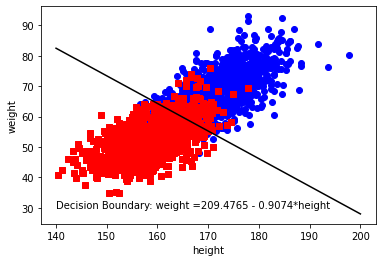

True Positive: 892 False Negative: 108 False Positive: 113 True Negative: 887
accuracy: 0.8895
True Positive rate: 0.892


In [ ]:
#決定境界(Decision Boundary)を与えるphiのパラメーター表示(引数t:決定境界を与える実数パラメーター)
def phi_DB(t):
  return np.array([t, - (w[0]/w[2]) - (w[1]/w[2])*t ])

#生の特徴量に戻す逆写像(今回はもとから線形分離可能なデータなので、恒等写像である)
def phi_inv_1(phi1): #phi(x)=x
  return phi1
def phi_inv_2(phi2): #phi(x)=x
  return phi2

#決定境界のパラメーター表示
def x_DB(t):
  phi_bound = np.empty((2,len(t)))
  phi_bound = phi_DB(t)
  
  #生の特徴量
  x_bound = np.empty((2,(len(t))))
  x_bound[0] = phi_inv_1(phi_bound[0])
  x_bound[1] = phi_inv_2(phi_bound[1])
  
  return x_bound

#t:決定境界の実数パラメーターを格納(xやphi(x)を与える)
min = 140
max = 200
t = np.linspace(min,max,max-min)

#決定境界を格納
d_bound = x_DB(t)

#可視化
fig, ax = plt.subplots()
# 先ほどの訓練データの可視化
ax.set_xlabel("height")
ax.set_ylabel("weight")
ax.scatter(male["height"],male["weight"] , marker='o', c='b') # 男
ax.scatter(female["height"],female["weight"] , marker='s',  c='r') #女
#決定境界の可視化
ax.plot(d_bound[0], d_bound[1],color="black")
ax.text(140,30, "Decision Boundary: "+"weight =" + str(round((- w[0])/w[2],4)) + " - " + str(round(w[1]/w[2],4)) + "*" + "height" )
plt.show()

#混同行列(confusion matrix)を求める
def confunc(male,female):
  tp = 0
  fn = 0
  tn = 0
  fp = 0

  m_wgt = male["weight"]
  m_wgt_bd = -(w[0]/w[2]) - (w[1]/w[2])*male["height"]
  f_wgt = female["weight"]
  f_wgt_bd = -(w[0]/w[2]) - (w[1]/w[2])*female["height"]
  

  for i in range(len(m_wgt)):
    if(m_wgt[i] >= m_wgt_bd[i]):
      tp += 1
    else:
      fn += 1

  for i in range(len(f_wgt)):
    if(f_wgt[i] < f_wgt_bd[i]):
      tn += 1
    else:
      fp += 1
  
  accuracy = (tp+tn)/(tp+fn+fp+tn)
  tp_rate = tp/(tp + fn)

  return tp,fn,tn,fp,accuracy,tp_rate

#混同行列、accuracy,True Positive rate
tp,fn,tn,fp,accuracy,tp_rate = confunc(male,female)
print("True Positive:",tp,"False Negative:",fn,"False Positive:",fp,"True Negative:",tn)
print("accuracy:", accuracy)
print("True Positive rate:",tp_rate)

訓練データに対して、分類器のAccuracyは約0.89,True Positive rate もほぼ同じで約0.89となった。

## 分類器のテスト
訓練データのロジスティック回帰によって得られた分類器が適切に機能するかテストする。(検証は実施しない)  
テストの方法は以下の通りである：  
  
・様々な無数のテストデータセットを生成し、各データセットについて分類器のAccuracyとTrue Positive rateを調べる。どのデータセットに対しても、AccuracyやTrue Positive rateが（0～1の範囲で）安定して高い値を示せば、分類器として性能が良いと言える。  
・現実のサンプリングにおけるサンプル数は、試行毎に毎回異なるし、ラベル毎(男と女)にも異なるのが自然である。よって、各試行のテストデータセットを生成する際には、そのサンプル数は乱数を使ってランダムに決めることとする。  
・通常、上記のような自然なサンプリングの場合、分類器としての性能を測定する指標としてより適切なのはTrue Positive rateである。

Random Seed No: accuracy , tp_rate
0 : 0.8704746580852776 , 0.8464912280701754
1 : 0.9044117647058824 , 0.918918918918919
2 : 0.8892086330935252 , 0.8154761904761905
3 : 0.8914174252275683 , 0.8810068649885584
4 : 0.9290540540540541 , 0.9180327868852459
5 : 0.8779123951537745 , 0.8708189158016147
6 : 0.8851142680667079 , 0.8741721854304636
7 : 0.9029649595687331 , 0.8571428571428571
8 : 0.8761061946902655 , 0.8625277161862528
9 : 0.8972602739726028 , 0.8952879581151832
10 : 0.9128205128205128 , 0.9132075471698113
11 : 0.8873152709359606 , 0.8783930510314875
12 : 0.8880794701986755 , 0.8647686832740213
13 : 0.896887159533074 , 0.8757396449704142
14 : 0.8795430944963655 , 0.8626817447495961
15 : 0.887881286067601 , 0.8530701754385965
16 : 0.8977149075081611 , 0.8913362701908958
17 : 0.8773148148148148 , 0.884430176565008
18 : 0.8865619546247818 , 0.8791946308724832
19 : 0.8818255908720456 , 0.8760330578512396
20 : 0.9034981905910736 , 0.8788732394366198
21 : 0.8724489795918368 , 0.866873

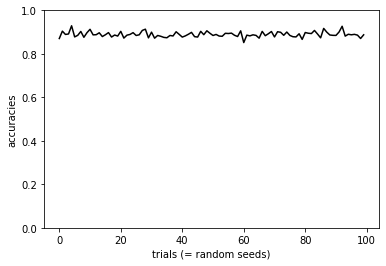

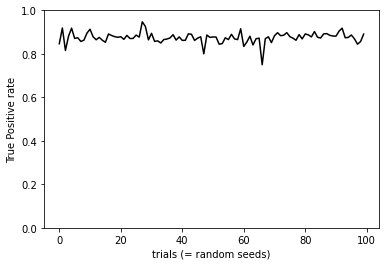



－－－－－－－－－以下は、無意味な文字列－－－－－－－－－


'\n#可視化関数\ndef visualize(someSeed,axj):\n  male, female, df = create_data(someSeed)\n  axj.set_title("Radom Seed No." + str(someSeed)) \n  axj.set_xlabel("height")\n  axj.set_ylabel("weight")\n  axj.scatter(male["height"],male["weight"],marker = "o",c="b")\n  axj.scatter(female["height"],female["weight"],marker = "s",c="r")\n\n#可視化\nfig, ax1 = plt.subplots()\nfig, ax2 = plt.subplots()\nfig, ax3 = plt.subplots()\nfig, ax4 = plt.subplots()\n\n#テストデータを生成してプロット\nprint("適当な乱数の種で生成したテストデータにてテスト")\nvisualize(5,ax1)\nvisualize(24,ax2)\nvisualize(11,ax3)\nvisualize(6,ax4)\n\n\n#決定境界の可視化\nax1.plot(d_bound[0], d_bound[1],color="black")\nax1.text(140,30, "Decision Boundary: "+"weight =" + str(round((- w[0])/w[2],4)) + " - " + str(round(w[1]/w[2],4)) + "*" + "height" )\n\nax2.plot(d_bound[0], d_bound[1],color="black")\nax2.text(140,30, "Decision Boundary: "+"weight =" + str(round((- w[0])/w[2],4)) + " - " + str(round(w[1]/w[2],4)) + "*" + "height" )\n\nax3.plot(d_bound[0], d_bound[1],color="black")

In [ ]:


#人工のデータセットを生成する関数(引数に乱数の種を指定できる)
def create_data(someSeed):
  np.random.seed(someSeed)

  #テストデータの個数をランダムにする
  num_test_m = np.random.randint(low=0, high=1000, size=None)
  num_test_f = np.random.randint(low=0, high=1000, size=None)
  male = pd.DataFrame()
  female = pd.DataFrame()
   
 
  m_height = np.random.normal(171.7,6.6,num_test_m)
  f_height = np.random.normal(158.3,5.7,num_test_f)
  m_bmi = np.random.normal(23.12,2,num_test_m)
  f_bmi = np.random.normal(20.82,2,num_test_f)

  male["height"] =np.sort(m_height)
  male["weight"] = (male["height"] * 0.01) ** 2 * m_bmi
  male["sex"] = 1 #男：1,女:0とする

  female["height"] = np.sort(f_height)
  female["weight"] = (female["height"] * 0.01) ** 2 * f_bmi
  female["sex"] = 0 #男：1,女:0とする
  
  return male,female

#乱数の種に対してデータを生成し、accuracyとtp_rateを返す関数
def cons(someSeed):
  male,female = create_data(someSeed)
  tp,fn,tn,fp,accuracy,tp_rate = confunc(male,female)
  #print("num of male:",len(male),"female:",len(female))
  return accuracy,tp_rate

#各試行に対するaccuracyとTrue Positive rate
rs_list = np.empty(0)
acc_list = np.empty(0)
tp_rate_list = np.empty(0)

print("Random Seed No:","accuracy",",","tp_rate")
for i in range(100):
  accuracy,tp_rate = cons(i)

  rs_list = np.append(rs_list,i)
  acc_list = np.append(acc_list,accuracy)
  tp_rate_list = np.append(tp_rate_list,tp_rate)

  print(i,":",accuracy,",",tp_rate)

#accuracyとTrue Positive rateの平均値、標準偏差、標準誤差
print("[mean ± SD]")
print("accuracy = ",np.mean(acc_list) ,"±",np.std(acc_list))
print("True Positive rate = ",np.mean(tp_rate_list),"±",np.std(tp_rate_list))
print("[mean ± SE]")
print("accuracy = ",np.mean(acc_list) ,"±",np.std(acc_list)/np.sqrt(len(acc_list)))
print("True Positive rate = ",np.mean(tp_rate_list),"±",np.std(tp_rate_list)/np.sqrt(len(tp_rate_list)))


fig, ax_acc = plt.subplots() 
ax_acc.set_ylim([0,1])
ax_acc.set_xlabel("trials (= random seeds)")
ax_acc.set_ylabel("accuracies")
ax_acc.plot(rs_list,acc_list,color="black")

fig, ax_tp = plt.subplots() 
ax_tp.set_ylim([0,1])
ax_tp.set_xlabel("trials (= random seeds)")
ax_tp.set_ylabel("True Positive rate")
ax_tp.plot(rs_list,tp_rate_list,color="black")
plt.show()

print("")
print("")
print("－－－－－－－－－以下は、無意味な文字列－－－－－－－－－")

"""
#可視化関数
def visualize(someSeed,axj):
  male, female, df = create_data(someSeed)
  axj.set_title("Radom Seed No." + str(someSeed)) 
  axj.set_xlabel("height")
  axj.set_ylabel("weight")
  axj.scatter(male["height"],male["weight"],marker = "o",c="b")
  axj.scatter(female["height"],female["weight"],marker = "s",c="r")

#可視化
fig, ax1 = plt.subplots()
fig, ax2 = plt.subplots()
fig, ax3 = plt.subplots()
fig, ax4 = plt.subplots()

#テストデータを生成してプロット
print("適当な乱数の種で生成したテストデータにてテスト")
visualize(5,ax1)
visualize(24,ax2)
visualize(11,ax3)
visualize(6,ax4)


#決定境界の可視化
ax1.plot(d_bound[0], d_bound[1],color="black")
ax1.text(140,30, "Decision Boundary: "+"weight =" + str(round((- w[0])/w[2],4)) + " - " + str(round(w[1]/w[2],4)) + "*" + "height" )

ax2.plot(d_bound[0], d_bound[1],color="black")
ax2.text(140,30, "Decision Boundary: "+"weight =" + str(round((- w[0])/w[2],4)) + " - " + str(round(w[1]/w[2],4)) + "*" + "height" )

ax3.plot(d_bound[0], d_bound[1],color="black")
ax3.text(140,30, "Decision Boundary: "+"weight =" + str(round((- w[0])/w[2],4)) + " - " + str(round(w[1]/w[2],4)) + "*" + "height" )

ax4.plot(d_bound[0], d_bound[1],color="black")
ax4.text(140,30, "Decision Boundary: "+"weight =" + str(round((- w[0])/w[2],4)) + " - " + str(round(w[1]/w[2],4)) + "*" + "height" )


plt.show()

"""

AccuracyよりTrue Positive rateの方が平均が若干低く、値のブレ(標準偏差)も大きいが、どちらも概ね0.85～0.90の範囲に収まっている。この分類器は、約85%の正答率を持つ、といえる。

# 備考・感想・雑記

シグモイド関数を使って重み付き行列$S$を計算する過程でトラブルがあった。パラメーター$w$の初期値の値、および$w\phi$の値がある境界を超えると、何故か$S$がゼロ行列として計算されてしまい、ヘッセ行列$H$もゼロ行列となってしまい、$H$の逆行列およびニュートン法の更新式を定義できない。パラメーターをある境界値よりも小さな値に調整すると、この問題は起こらない。恐らく、PythonもしくはNumPyの計算桁数に関する仕様の問題だと思われる。根本的な原因は分からなかったため、「$w\phi$の値がつねに小さな値に収まるようにパラメーターの初期値を調整する」というその場しのぎの解決策を講じることにした。

ヘッセ行列を求める過程で問題が発生した。パラメーター$w$の値と訓練データの特徴量$\Phi$の値によっては、得られるヘッセ行列が正則でない場合があり、その場合はニュートン法の更新式を定義することが出来ない。コンソールには、該当箇所に以下のようなエラーが検出された：
LinAlgError: Singular matrix
解決の方針は、**「ヘッセ行列が必ず正則になるような、理論的な条件およびプログラム実装上の条件を突き止めて、パラメーター$w$が取りうる値の範囲に制限を加えること**」であると思われる。しかし、その条件が分からず、解決出来なかった。(正則でないヘッセ行列に出会ったときどうするべきかhttps://dash.harvard.edu/bitstream/handle/1/4214881/King_HessianNotInvertible.pdf?sequence=2)
【追記】
一般化逆行列という道具の存在を知り、使うことにした。これを使うと、逆行列を求められない状況(正則でないなど)で発生するはずのエラーをスルーすることが出来る。


交差エントロピー誤差関数を定義する過程で問題が発生した。交差エントロピー誤差関数を書き下したコードに対して、以下のようなエラーが検出された：
ValueError: cannot reindex from a duplicate axis
調べてみたが、何が問題なのか分からず、解決できなかった。  
追記:直接の原因になっていたのか分からないが、訓練データを生成する際に複数のDataFrameを結合するとき、pandasの仕様上indexが重複してしまうらしい。これを回避するためには、DataFrameを結合する際は毎回何らかの方法でindexの振りなおしをすると良い。あるDataFrame(df)のindexが重複しているかは、df.index.duplicated()で調べられる。

追記:
上記の様々なトラブルは、以下が原因だったようである:
・交差エントロピー誤差関数en_errorのコードに、インデントのミスがあった。
・パラメーターの初期値$w^{0}$の選び方の問題で、ニュートン法のステップが進んでパラメーターが変化する時に新たに計算される$s_i = \sigma(w^T_{i}\phi$の値が、上述の計算の分解能を超えて極端に1に近付いてしまい、新たな$S$,$H$がゼロ行列として計算されてしまったため、と思われる。試しに、パラメーターの初期値を$w^{0}=(0,0,0)^T$に取り直してみたところ、各ステップで$S$と$H$はゼロ行列にならず、交差エントロピー誤差関数の値が徐々に減少してある値に漸近していく様子を観察できた。アルゴリズムは正常な動作したようである。

上述の「計算の分解能を超えているためにヘッセ行列がゼロになってしまった」という仮説だが、Wolfram Alphaを使って計算してみたところ、せいぜい小数点以下30桁程度に収まっていたので、少なくとも浮動小数点の小数点桁数の限界($10^{-308}$の桁まで可能)というわけではないようである。根本的な原因ははっきり分からなかった。

おそらく一般的には、損失関数の形が複雑な形をしている場合など、何らかの方法(関数を解析的に分析するなど)である程度当たりを付けて初期パラメーターの選び方を工夫しなければ、最小でない極小点に収束してしまうことも考えられる。

print("w・phi[0]の値:",wDotPhiZero) #エラーチェック用
print("w・phi[i]の値が30(w_1=0.2)を超えるあたりから、sigmoid関数の（numpy上での？）分解能の限界に近づく。45(w_1=0.3)では完全アウトで、Sがゼロ行列として認識されてしまう。")
print("しかし、Wolfram Alphaによるとw・phi[i]=45では10^{-30}程度で、浮動小数点としては全然余裕がある。(浮動小数点は10^{-308}くらいまで計算できる)よくわからない。")
print("とにかく、どうやら、pythonが使っている計算方法だと、a=45、46の間に、σ(a) = 1となってしまう境界があるらしい。Wolfram Alphaによると浮動小数点の有効数字の限界には遠く及ばないにも関わらず。")
print("その場しのぎの解決策→σ(a)の引数aが30以下に収まるように、wベクトルの値を制限する。")


実装自体にかなり時間がかかってしまった。よりスムーズに進められるように、コーディングやエラーチェックの熟練に励みたい。

一般化逆行列(擬逆行列)が実際に使われる場面を観察できた。